In [1]:
import numpy as np
import pandas as pd

from statsbombpy import sb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt
from mplsoccer import Pitch

In [2]:
shots = pd.read_csv('shots.csv')
shots.shape

C:\Users\Jeet\AppData\Local\Temp\ipykernel_28780\491741905.py:1: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  shots = pd.read_csv('shots.csv')


(9071, 123)

In [3]:
model_df = pd.read_csv('model_df.csv')
model_df.shape

(9071, 7)

In [4]:
feature_cols = ['distance', 'angle', 'shot_body_part', 'shot_type', 'play_pattern']

In [5]:
X = pd.get_dummies(model_df[feature_cols], drop_first=True)
y = model_df['is_goal'].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic Regression Model

In [7]:
clf = LogisticRegression(max_iter=4000)
clf.fit(X_train, y_train)

p_test = clf.predict_proba(X_test)[:, 1]
print("Log loss:", log_loss(y_test, p_test))
print("ROC-AUC:", roc_auc_score(y_test, p_test))

Log loss: 0.26993645676165484
ROC-AUC: 0.8007087213729279


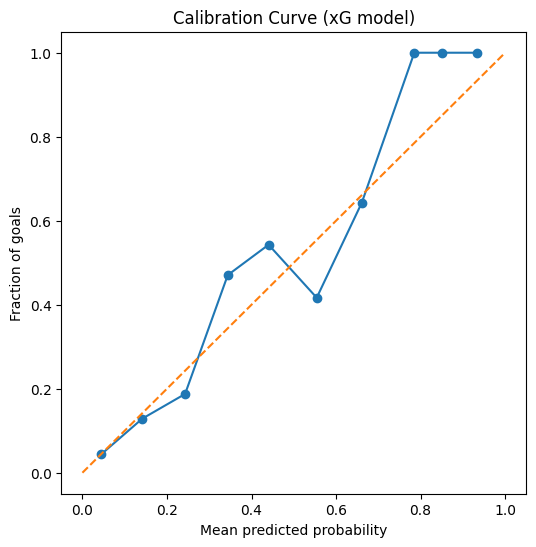

In [8]:
frac_pos, mean_pred = calibration_curve(y_test, p_test, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(mean_pred, frac_pos, marker='o')
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of goals")
plt.title("Calibration Curve (xG model)")
plt.show()

### Shot Map

In [9]:
model_df = model_df.reset_index(drop=True)
model_df['xG'] = clf.predict_proba(X)[:, 1]

# bring x,y back (align via index from the original filtered shots)
# easiest: rebuild a plotting df from the same rows used in model_df
plot_df = shots.loc[model_df.index, ['x','y']].copy()
plot_df['xG'] = model_df['xG'].values
plot_df['is_goal'] = model_df['is_goal'].values

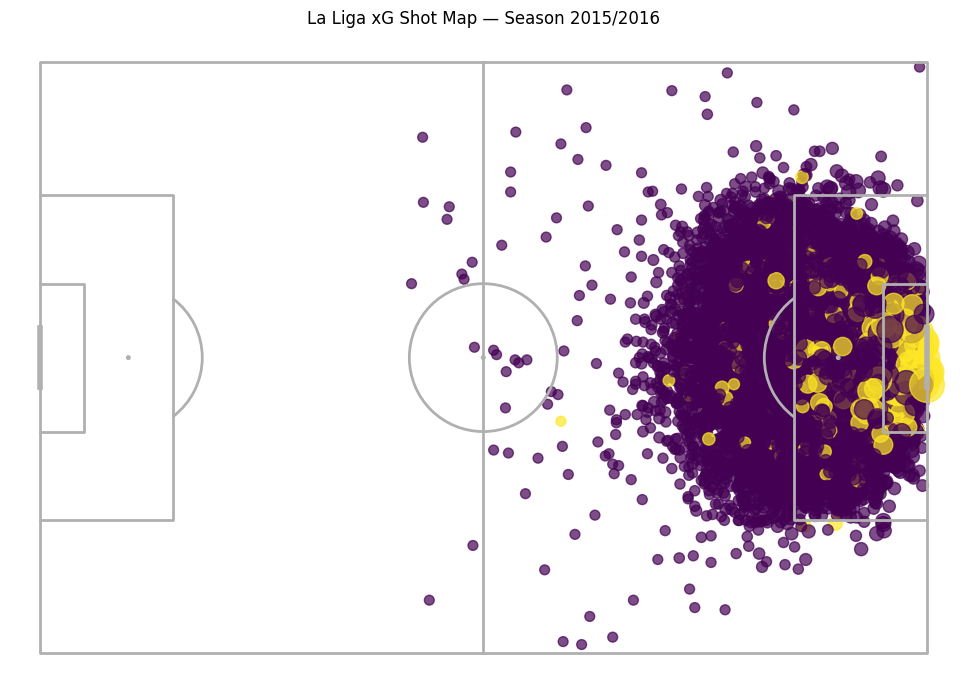

In [10]:
pitch = Pitch(pitch_type='statsbomb', line_zorder=2)
fig, ax = pitch.draw(figsize=(10, 7))

# scale marker size by xG
sizes = 50 + 600 * plot_df['xG']

pitch.scatter(plot_df['x'], plot_df['y'],
              s=sizes,
              c=plot_df['is_goal'],
              ax=ax,
              alpha=0.7)

ax.set_title(f"La Liga xG Shot Map — Season 2015/2016")
plt.show()

# XGBoost

In [11]:
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
pos_weight

np.float64(8.597883597883598)

In [27]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
     eval_metric="logloss",
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    min_child_weight=50,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=pos_weight,
    random_state=42
)

In [28]:
xgb_model.fit(X_train, y_train)

xgb_p_test = xgb_model.predict_proba(X_test)[:, 1]
print("Log loss:", log_loss(y_test, xgb_p_test))
print("ROC-AUC:", roc_auc_score(y_test, xgb_p_test))

Log loss: 0.5133760487225476
ROC-AUC: 0.7860722258016231


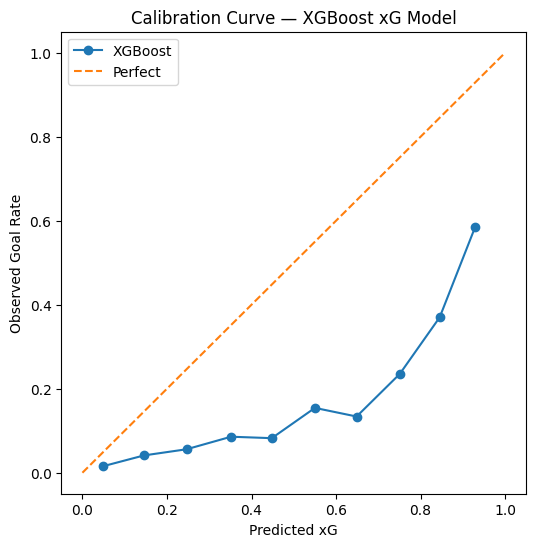

In [29]:
frac_pos, mean_pred = calibration_curve(y_test, xgb_p_test, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(mean_pred, frac_pos, marker='o', label='XGBoost')
plt.plot([0,1],[0,1],'--', label='Perfect')
plt.xlabel("Predicted xG")
plt.ylabel("Observed Goal Rate")
plt.title("Calibration Curve — XGBoost xG Model")
plt.legend()
plt.show()

In [30]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_xgb = CalibratedClassifierCV(
    xgb_model,
    method="isotonic",
    cv=3
)

calibrated_xgb.fit(X_train, y_train)
p_test_cal = calibrated_xgb.predict_proba(X_test)[:, 1]

In [31]:
frac_pos, mean_pred = calibration_curve(y_test, p_test_cal, n_bins=10)

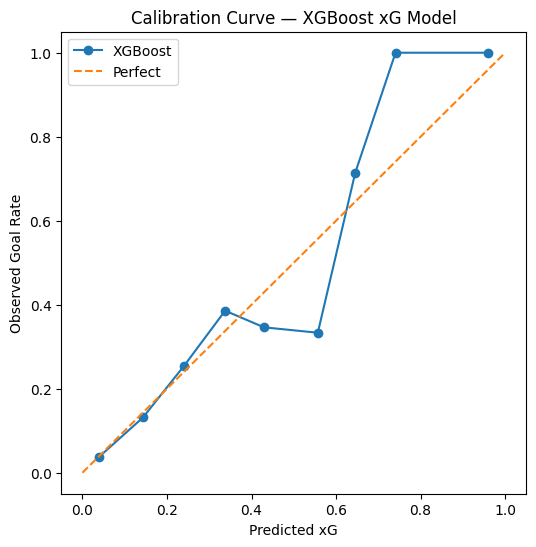

In [32]:
plt.figure(figsize=(6,6))
plt.plot(mean_pred, frac_pos, marker='o', label='XGBoost')
plt.plot([0,1],[0,1],'--', label='Perfect')
plt.xlabel("Predicted xG")
plt.ylabel("Observed Goal Rate")
plt.title("Calibration Curve — XGBoost xG Model")
plt.legend()
plt.show()

In [35]:
from sklearn.metrics import log_loss

print("Linear Regression Model log loss:", log_loss(y_test, p_test))
print("Uncalibrated XGB log loss:", log_loss(y_test, xgb_p_test))
print("Calibrated XGB log loss:", log_loss(y_test, p_test_cal))

Linear Regression Model log loss: 0.26993645676165484
Uncalibrated XGB log loss: 0.5133760487225476
Calibrated XGB log loss: 0.277623013210513


In [36]:
calibrated_xgb_sigmoid = CalibratedClassifierCV(
    xgb_model,
    method="sigmoid",
    cv=5
)

calibrated_xgb_sigmoid.fit(X_train, y_train)
p_test_cal_sig = calibrated_xgb_sigmoid.predict_proba(X_test)[:, 1]

In [39]:
print("Calibrated XGB log loss isotonic:", log_loss(y_test, p_test_cal))
print("Calibrated XGB log loss sigmoid:", log_loss(y_test, p_test_cal_sig))

Calibrated XGB log loss isotonic: 0.277623013210513
Calibrated XGB log loss sigmoid: 0.2815769292215804


In [37]:
frac_pos, mean_pred = calibration_curve(y_test, p_test_cal, n_bins=10)

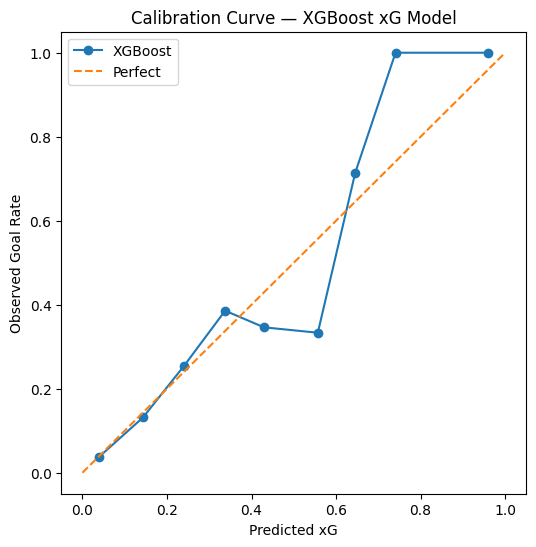

In [38]:
plt.figure(figsize=(6,6))
plt.plot(mean_pred, frac_pos, marker='o', label='XGBoost')
plt.plot([0,1],[0,1],'--', label='Perfect')
plt.xlabel("Predicted xG")
plt.ylabel("Observed Goal Rate")
plt.title("Calibration Curve — XGBoost xG Model")
plt.legend()
plt.show()